In [1]:
from DirectDetection import DirectDetection as DD
import numpy as np
import matplotlib.pyplot as plt
from sigfig import round

In [2]:
DD.init()

Found: 114 files...Done!


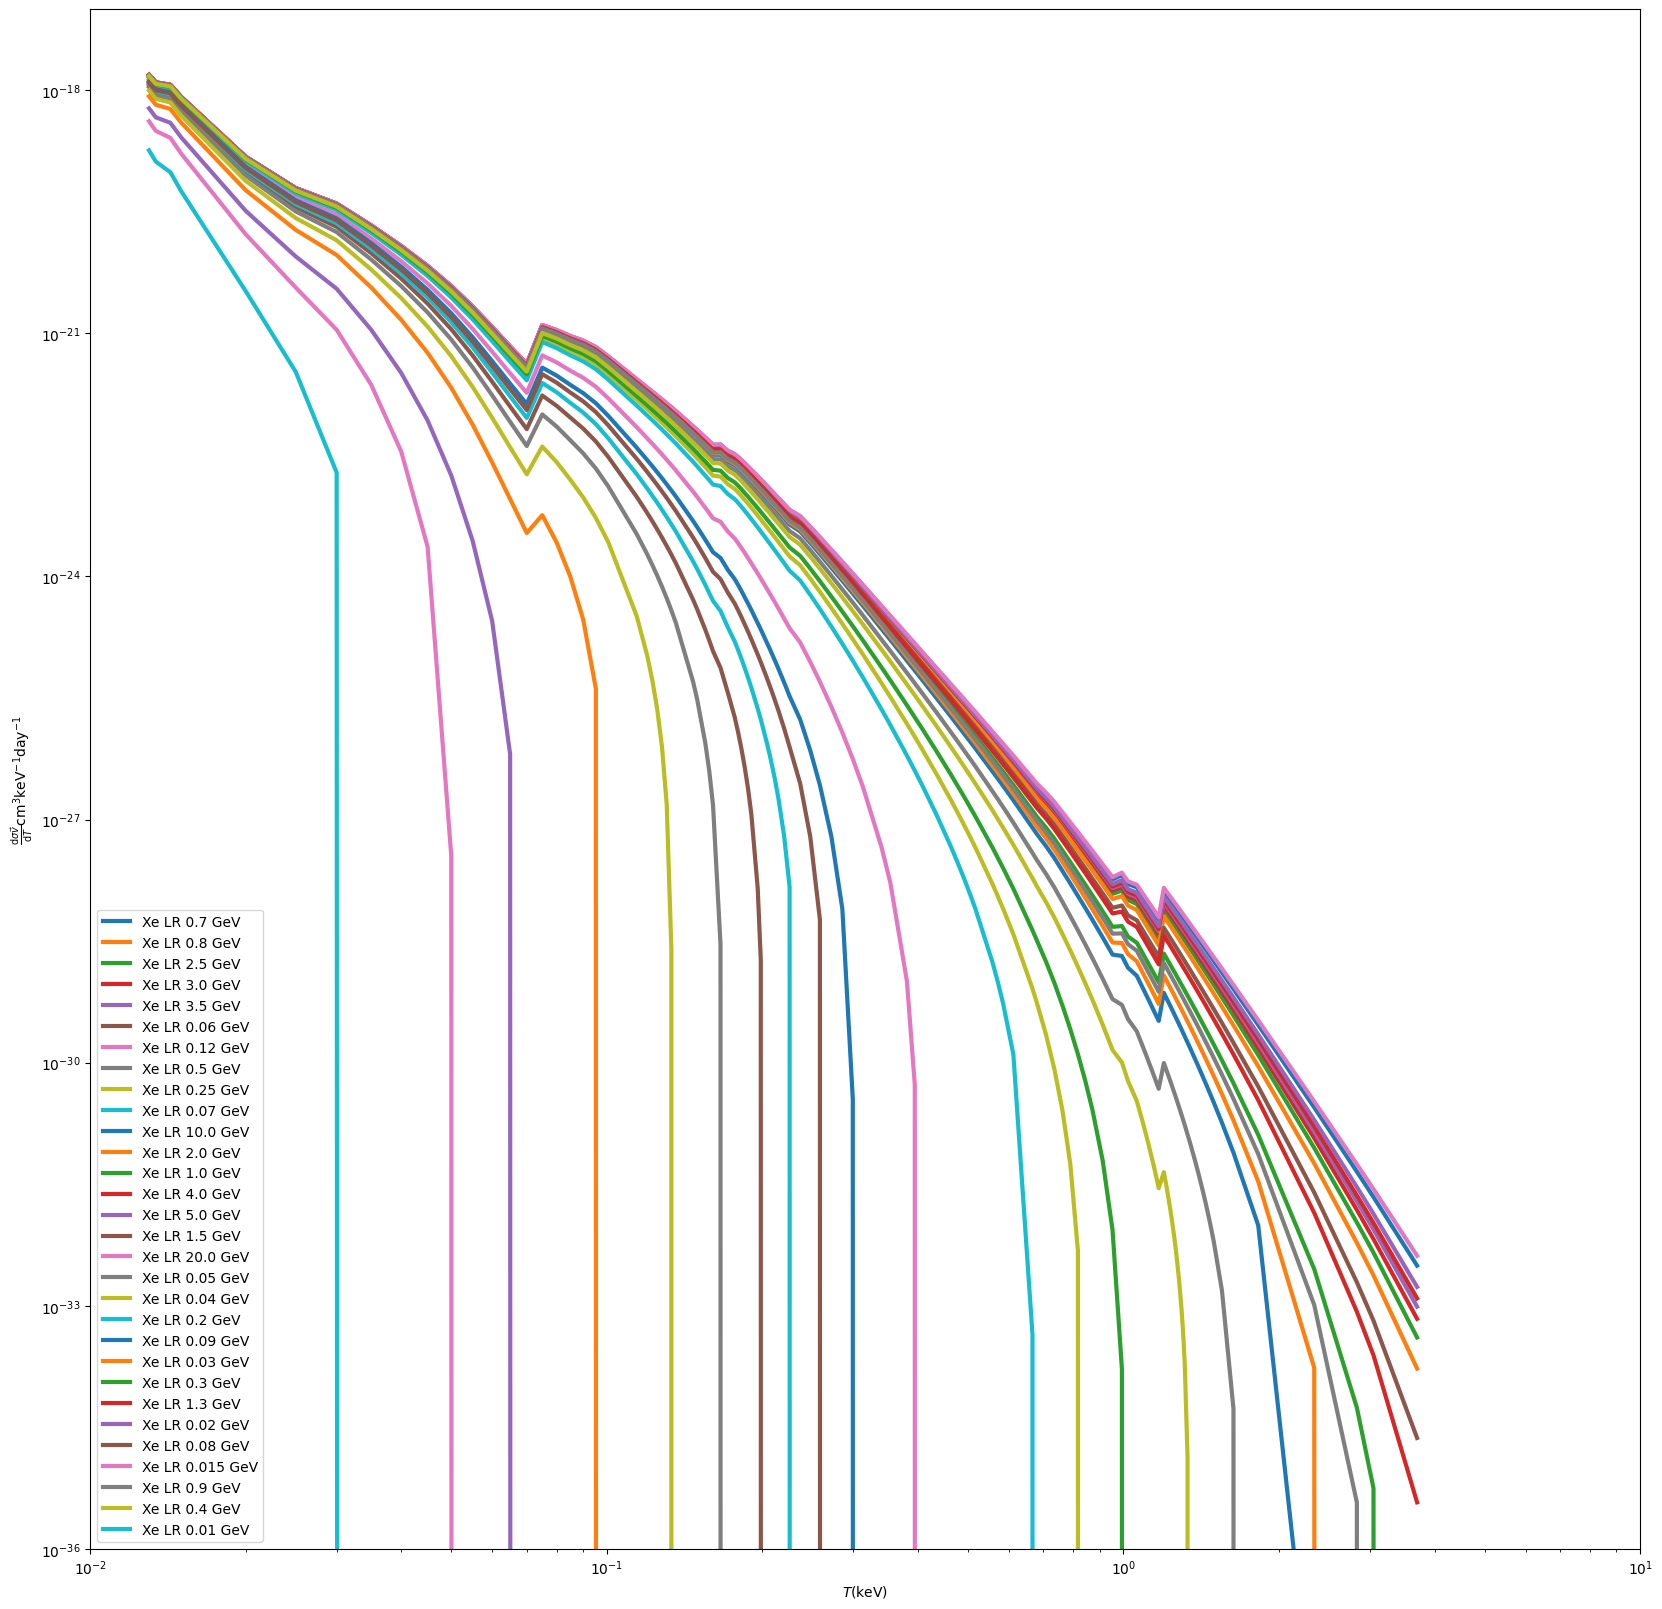

In [3]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)

for fname in DD.get_valid_fnames("Xe", "LR"):
    DD.get_plot(fname).plot()
    
plt.legend(loc="lower left")
plt.show()

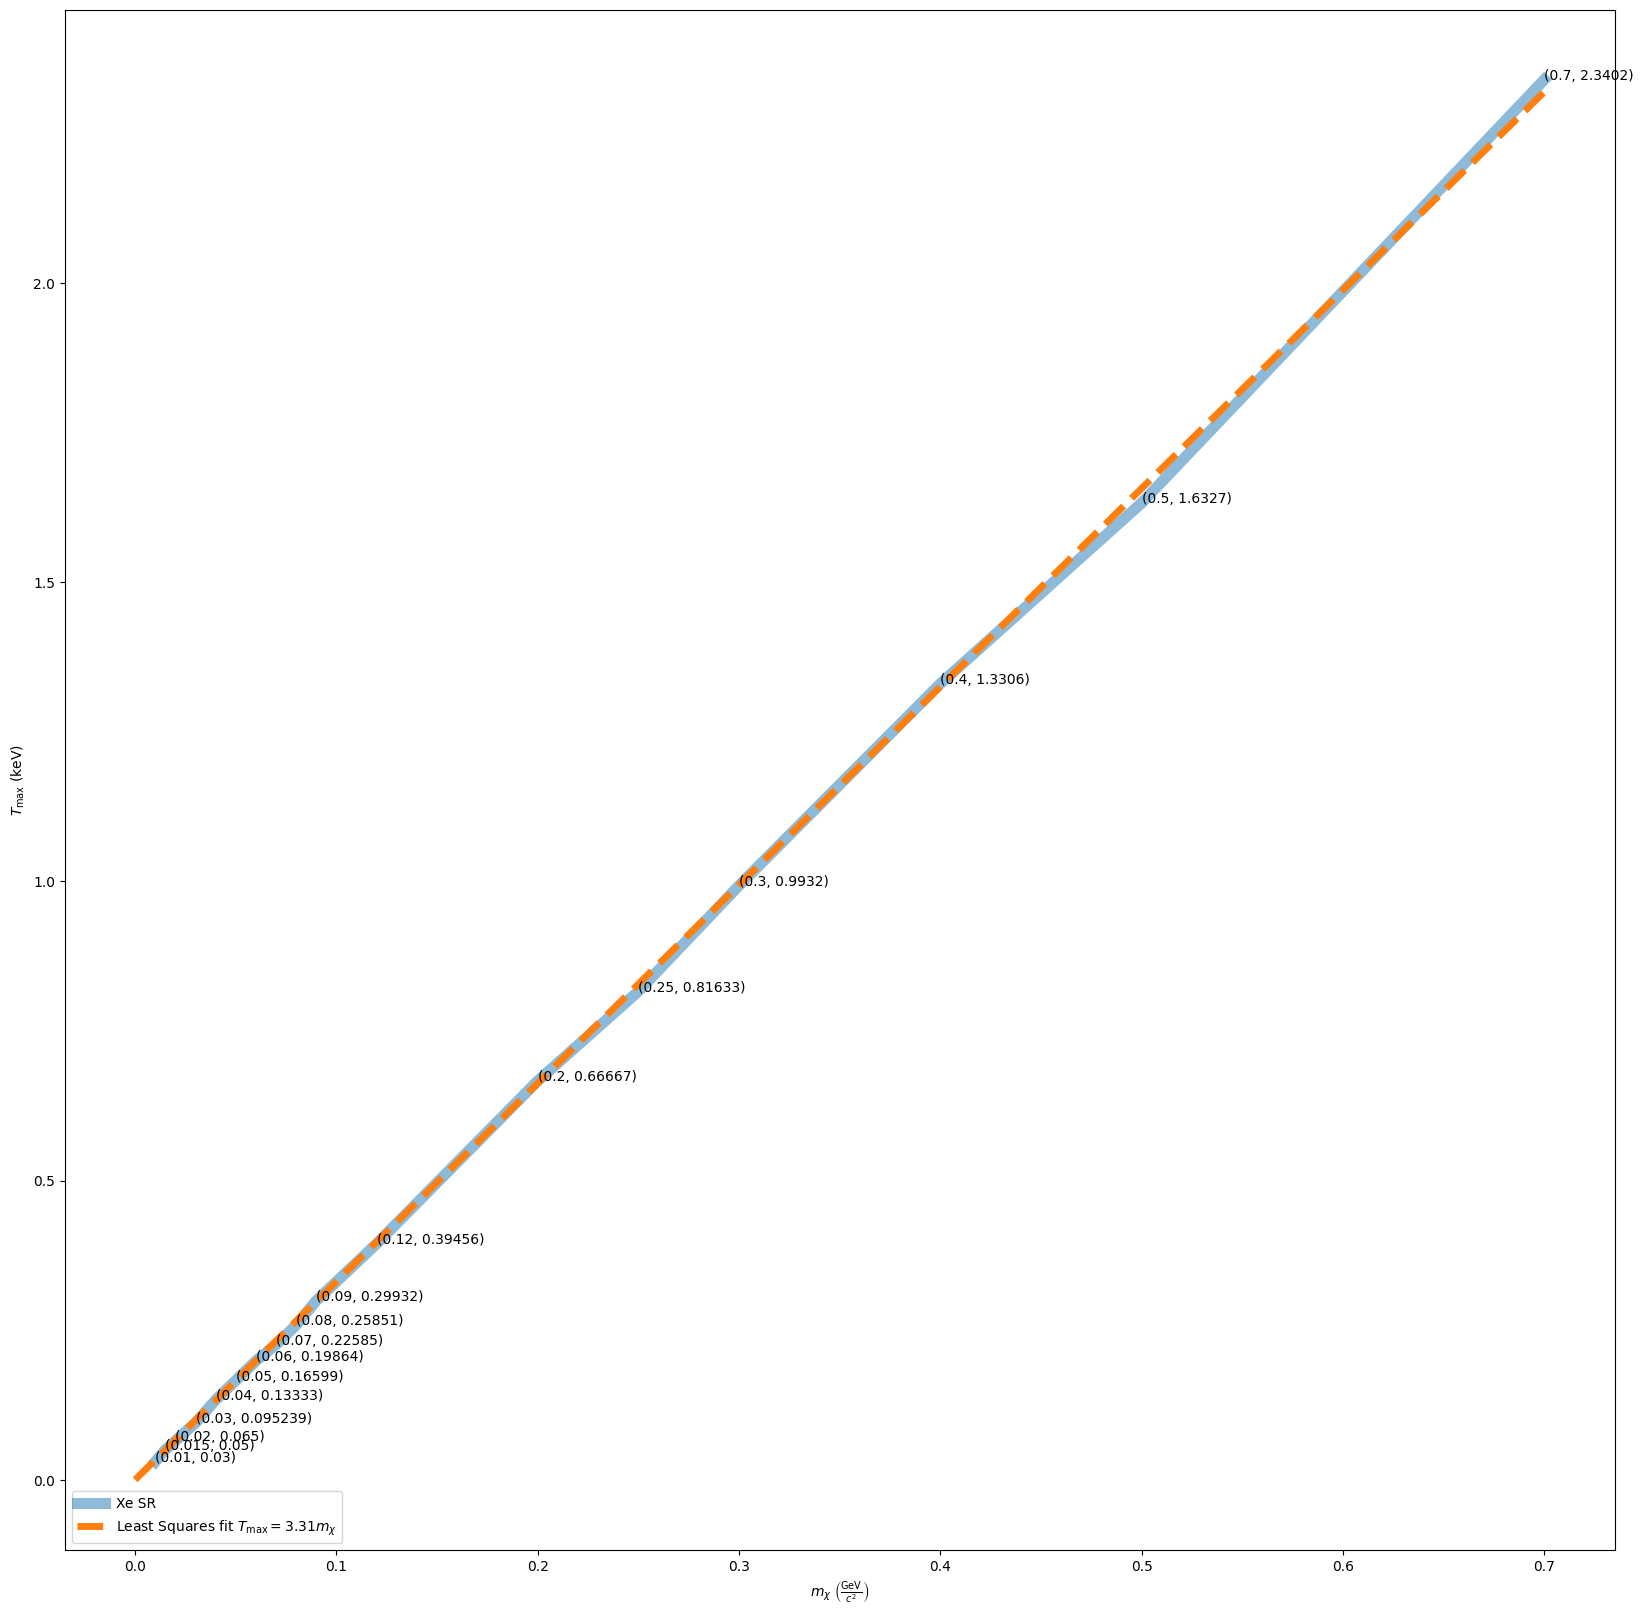

In [4]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)

maxGeV = 0.7
Tmaxes = []
Masses = []

for fname in DD.get_valid_fnames("Xe", "SR"):
    _, _, _, en, _ = DD.parse_fname(fname)
    if en > maxGeV:
        continue
    Tmaxes.append(DD.get_tmax(fname))
    Masses.append(en)

# Main plot
tm_mat = DD.get_tmax_matrix(Masses, Tmaxes, 5)
plt.plot(tm_mat[:, 0], tm_mat[:, 1], label = "Xe SR", linewidth = 8, alpha = 0.5)

# Annotations
ax = plt.gca()
for xy in tm_mat:
    xy = tuple(xy)
    ax.annotate("(%s, %s)" % xy, xy=xy, textcoords="data")

# Fit
x = np.linspace(0, maxGeV, 2)
m = DD.fit_tmaxes(tm_mat)
plt.plot(x, x* m, "--", alpha = 1, linewidth = 5, label = r"Least Squares fit $T_{\text{max}} = " + str(round(m,3)) + r"m_{\chi}$")

# Show
plt.ylabel(r"$T_\text{max}$ (keV)")
plt.xlabel(r"$m_{\chi}$ $\left(\frac{\text{GeV}}{c^2}\right)$")
plt.legend(loc="lower left")
plt.show()

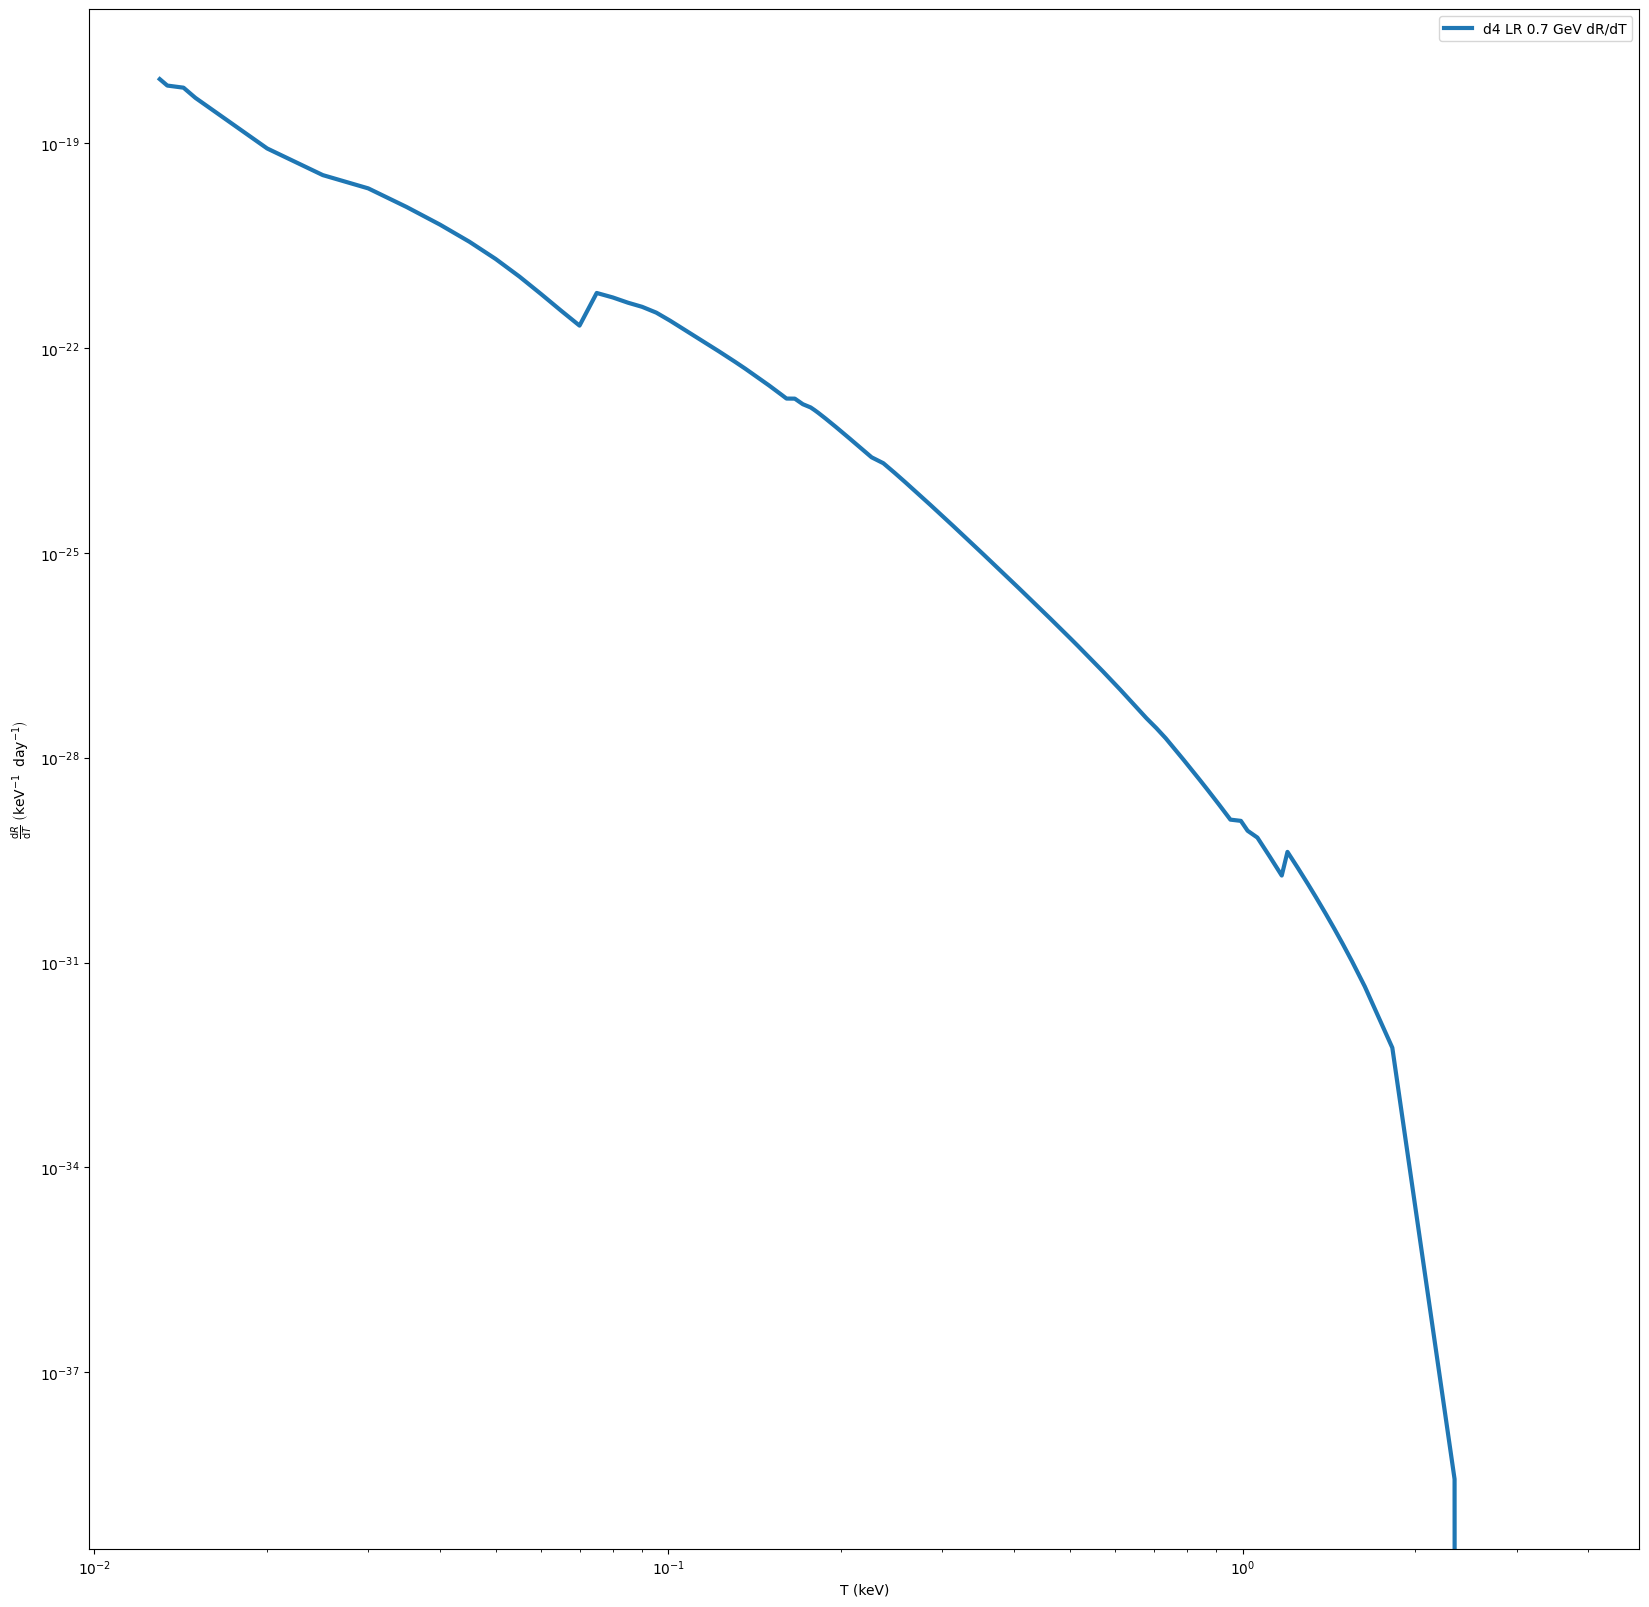

In [5]:
# N_T = 1.4453137824e+25
N_T = 1
rho_x = 0.4  # GeV cm^-3

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)
for fname in DD.get_valid_fnames("Xe", "LR"):
    mol,_,rt, m_x, _ = DD.parse_fname(fname)
    T, dsv_dt = np.loadtxt(fname).T
    dr_dt = N_T * rho_x / m_x * dsv_dt

    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("T (keV)")
    plt.ylabel(r"$\frac{\text{d}R}{\text{d}T}\;\left(\text{keV}^{-1}\;\;\text{day}^{-1}\right)$")
    plt.plot(T, dr_dt, linewidth = 3, label = f"{mol} {rt} {m_x} GeV dR/dT")
    break
plt.legend(loc="upper right")
plt.show()

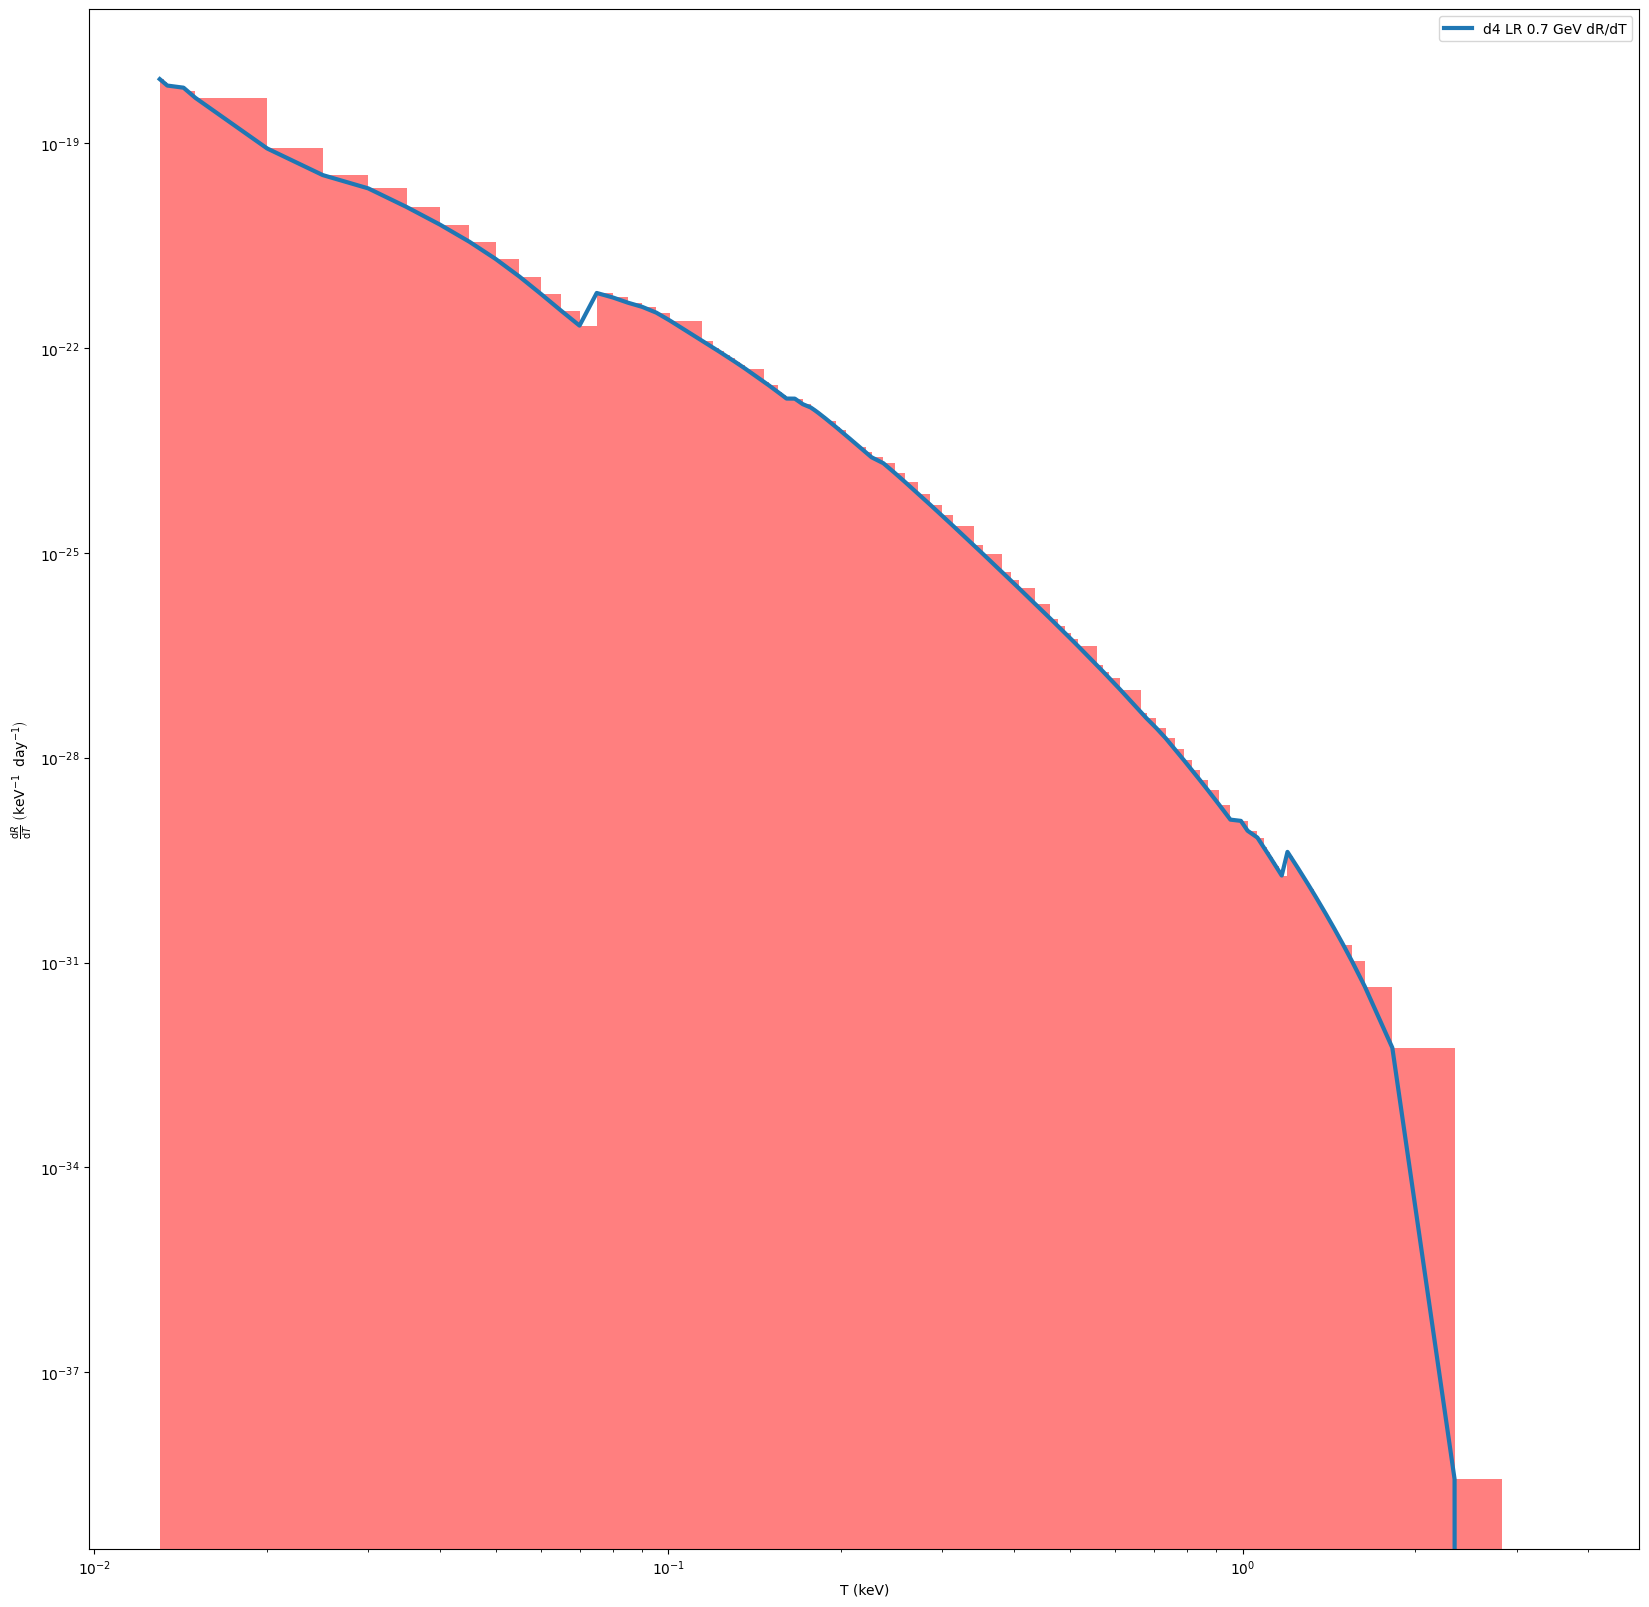

In [6]:
# N_T = 1.4453137824e+25
N_T = 1
rho_x = 0.4  # GeV cm^-3

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)
for fname in DD.get_valid_fnames("Xe", "LR"):
    mol,_,rt, m_x, _ = DD.parse_fname(fname)
    T, dsv_dt = np.loadtxt(fname).T
    dr_dt = N_T * rho_x / m_x * dsv_dt

    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("T (keV)")
    plt.ylabel(r"$\frac{\text{d}R}{\text{d}T}\;\left(\text{keV}^{-1}\;\;\text{day}^{-1}\right)$")
    ind = 0
    widths = np.array([T[i+1] - T[i] for i in range(len(T) - 1)] + [0])
    plt.bar((T + widths/2)[ind:], dr_dt[ind:], width=widths[ind:], color="red", alpha=0.5)
    plt.plot(T, dr_dt, linewidth = 3, label = f"{mol} {rt} {m_x} GeV dR/dT")
    break
plt.legend(loc="upper right")
plt.show()

[np.float64(15.0), np.float64(20.0), np.float64(25.0), np.float64(30.0), np.float64(35.0), np.float64(40.0), np.float64(45.0), np.float64(50.0), np.float64(55.0), np.float64(60.0), np.float64(65.0), np.float64(70.0), np.float64(75.0), np.float64(80.0)]


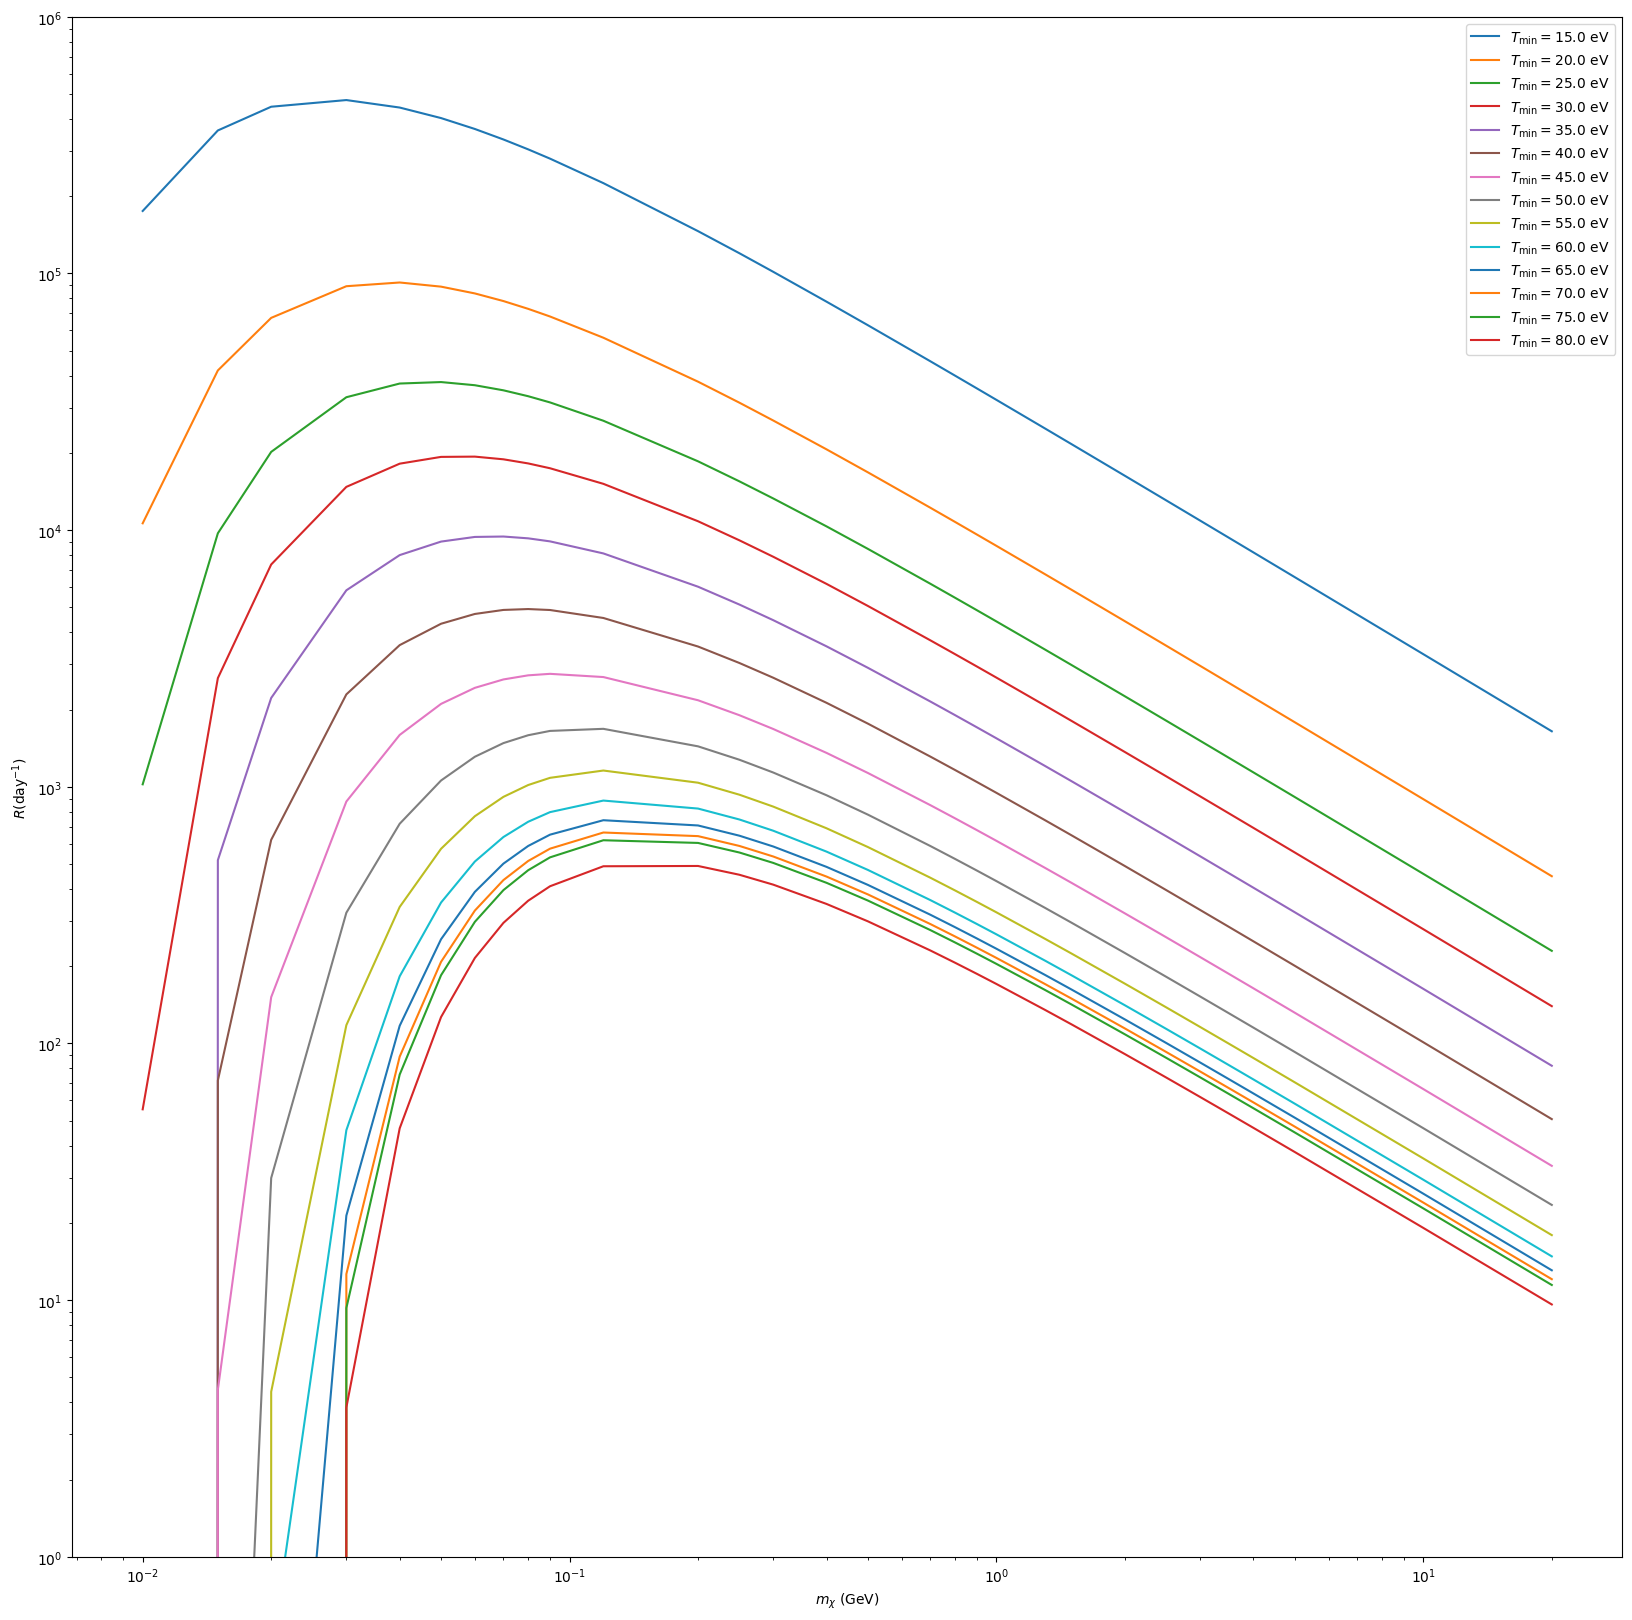

In [20]:
def cum_area(steps, values):
    total = 0
    totals = []
    totals.append(0)
    for i in range(len(steps)- 2, -1, -1):
        step_size = steps[i + 1] - steps[i]
        total += step_size * values[i]
        totals.append(total)
    return totals[::-1]
    
N_T = 1.4453137824e+25
# N_T = 1
rho_x = 0.4  # GeV cm^-3

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)
m_xs = []
es = list(np.linspace(15, 80, 14))
print(es)
rs = [[] for e in es]
for fname in DD.get_valid_fnames("Xe", "LR"):
    mol,_,rt, m_x, _ = DD.parse_fname(fname)
    T, dsv_dt = np.loadtxt(fname).T
    dr_dt = N_T * rho_x / m_x * dsv_dt

    integrated = np.array(cum_area(T, dr_dt))
    m_xs.append(m_x)
    for k in range(len(rs)):
        rs[k].append(integrated[np.where(T == es[k]*1e-3)][0])
    # r25.append(integrated[np.where(T == 0.025)][0])
    # r50.append(integrated[np.where(T == 0.05)][0])
    
    # plt.xlabel(r"$T_{\text{min}}$ (keV)")
    # plt.ylabel(r"$\int_{T_\text{min}}^{T_\text{max}} \frac{\text{d}R}{\text{d}T} \text{d}T\;\left(\text{day}^{-1}\right)$")
    # plt.ylabel(r"$R(T_\text{min})$")
    # plt.plot(T, integrated, linewidth = 3, label = f"{mol} {rt} {m_x} GeV dR/dT")
    # break
# plt.legend(loc="upper right")
# plt.show()


plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$m_\chi$ (GeV)")
plt.ylabel(r"$R (\text{day}^{-1})$")
arr = np.vstack([m_xs, *rs]).T
arr = arr[arr[:,0].argsort()]
m_xs, rs = arr.T[0], arr.T[1:]
plt.gca().set_ylim([1, 1e6])
for i in range(len(es)):
    plt.plot(m_xs, rs[i], label=r"$T_{\text{min}} = " + str(es[i]) + "$ eV")
# plt.plot(m_xs, r13_2, label=r"$T_{\text{min}} = 13.2$ eV")
# plt.plot(m_xs, r25, label=r"$T_{\text{min}} = 25$ eV")
# plt.plot(m_xs, r50, label=r"$T_{\text{min}} = 50$ eV")
plt.legend(loc = "upper right")
plt.show()